In [1]:
from tensorflow import keras
from numpy import dstack
from keras.models import load_model
 

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '..//Datasets//UCI HAR Dataset//')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '..//Datasets//UCI HAR Dataset//')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

## Loading Models:

- **model1: 3levels on CNN (4layers in each)(takes 4input)**

In [5]:
model1 = load_model("Models_h5//model1.h5")

- **model2: 3levels on CNN (4layers in each) , parallaly 1LSTM layer (takes 5inputs)**

In [6]:
model2 = load_model("Models_h5//model2.h5")

- **model3: Timdistributed ConvLSTM(takes 1input)**

In [7]:
model3 = load_model("Models_h5//model3.h5")

- **model4: 2layered LSTM(takes 1input)**

In [8]:
model4 = load_model("Models_h5//model4.h5")

##  Running the member models to make predictions on the validation set, and create a new training set with the resulting predictions

In [9]:
n_steps, n_length = 4, 32
X_val3 = X_val.reshape((X_val.shape[0], n_steps, n_length,9))

In [10]:
stackX_train = None

In [11]:
##Output model1
yhat = model1.predict([X_val,X_val,X_val,X_val], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train =yhat

In [12]:
##Output model2
yhat = model2.predict([X_val,X_val,X_val,X_val,X_val], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train = dstack((stackX_train, yhat))

In [13]:
##Output model3

yhat = model3.predict(X_val3, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train = dstack((stackX_train, yhat))

In [14]:
##Output model4
yhat = model4.predict(X_val, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train = dstack((stackX_train, yhat))

In [15]:
stackX_train.shape

(1, 2206, 4)

In [16]:
stackX_train = stackX_train.reshape((stackX_train.shape[0]*stackX_train.shape[1],stackX_train.shape[2]))

In [17]:
stackX_train.shape####it is the training set of the ensembling classifier

(2206, 4)

In [18]:
y_val.shape

(2206, 1)

In [19]:
from sklearn.ensemble import RandomForestClassifier
# rfc=RandomForestClassifier(n_estimators=10,criterion='gini',
#                              max_features='log2',min_samples_leaf=1,min_samples_split=7,max_depth=560,random_state=100)
EnsemHAR=RandomForestClassifier(n_estimators= 2000,
 min_samples_split= 7,
 min_samples_leaf= 2,
 max_features='sqrt',
 max_depth= 890,
 criterion= 'entropy')

In [20]:
from sklearn.model_selection import RandomizedSearchCV 
n_estimators=[int(x) for x in np.linspace(start=200, stop=2000, num=10)]# here we are taking a list of 10 diffrent numbers ranging 
#from 200 -2000 which are the number of decision trees for 10 different model of random forest 
max_features=['auto','sqrt','log2']#discussed before
max_depth=[int(x) for x in np.linspace(10,1000,10)]#10 different max_depth values for 10 different model 
min_samples_leaf = [1,2,4,6,8]
min_samples_split = [1,3,4,5,7,9]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [1, 3, 4, 5, 7, 9], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [61]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)

In [20]:
y_val_1D=np.ravel(y_val)

In [21]:
EnsemHAR.fit(stackX_train,y_val_1D)


RandomForestClassifier(criterion='entropy', max_depth=890, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=2000)

In [63]:
rf_randomcv.fit(stackX_train,y_val_1D)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\bhatt\anaconda3\envs\dLenv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
51 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bhatt\anaconda3\envs\dLenv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bhatt\anaconda3\envs\dLenv\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\bhatt\anaconda3\envs\dLenv\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [1, 3, 4, 5, 7, 9],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [211]:
rf_randomcv.best_params_


NameError: name 'rf_randomcv' is not defined

In [65]:
ensembler=rf_randomcv.best_estimator_

##  Now evaluate the ensemble on the test set:
#### Create stacked model input dataset as outputs from the ensemble;

In [22]:
stackX_test = None

In [23]:
n_steps, n_length = 4, 32
testX3 = testX.reshape((testX.shape[0], n_steps, n_length,9))

In [24]:
##Output model1
yhat = model1.predict([testX,testX,testX,testX], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = yhat

In [25]:
##Output model2
yhat = model2.predict([testX,testX,testX,testX,testX], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = dstack((stackX_test, yhat))

In [26]:
##Output model3

yhat = model3.predict(testX3, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = dstack((stackX_test, yhat))

In [27]:
##Output model4
yhat = model4.predict(testX, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = dstack((stackX_test, yhat))

In [28]:
stackX_test.shape

(1, 2947, 4)

In [29]:
stackX = stackX_test.reshape((stackX_test.shape[0]*stackX_test.shape[1],stackX_test.shape[2]))

In [30]:
stackX_test.shape

(1, 2947, 4)

In [31]:
stackX_test = stackX_test.reshape((stackX_test.shape[0]*stackX_test.shape[1],stackX_test.shape[2]))

In [32]:
stackX_test.shape

(2947, 4)

In [33]:
predy=EnsemHAR.predict(stackX_test)


In [34]:
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(testy,predy)
print(cm)
print(acc(testy,predy))
print(classification_report(testy,predy))

[[492   3   1   0   0   0]
 [  0 454   6  10   1   0]
 [  1   5 414   0   0   0]
 [  0   4   0 395  92   0]
 [  0   0   0  33 499   0]
 [  0   0   0   0   0 537]]
0.9470648116728877
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       0.97      0.96      0.97       471
           2       0.98      0.99      0.98       420
           3       0.90      0.80      0.85       491
           4       0.84      0.94      0.89       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [36]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))

In [37]:
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'WALKING_UPSTAIRS'),
 Text(0, 2.5, 'WALKING_DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

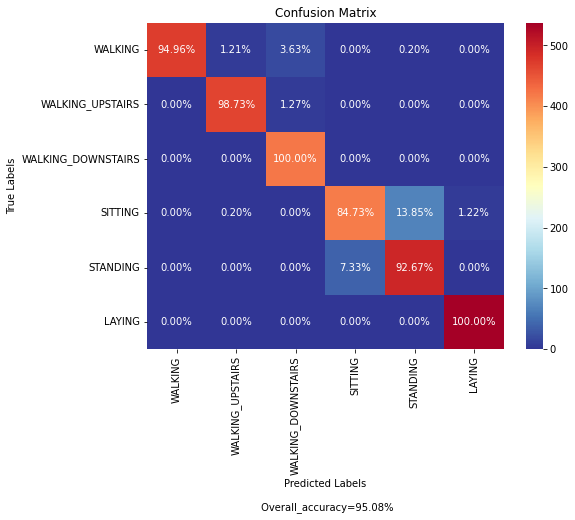

In [38]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(testy,predy)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'],rotation=90)
ax.yaxis.set_ticklabels(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'],rotation=360)
plt.savefig('Metrics//ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

In [35]:
##ROC curve plot
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}

roc_auc={}

class_number = 6
predy_one_hot=to_categorical(predy)


In [36]:
for i in range(class_number):    
    fpr[i], tpr[i], _ = roc_curve(testy, predy_one_hot[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [37]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(class_number)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_number):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= class_number

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

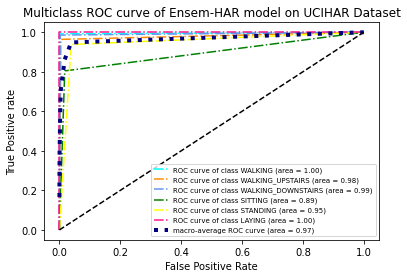

In [38]:
from itertools import cycle
colors = cycle(["aqua", "darkorange", "cornflowerblue","green","yellow","deeppink"])
n_classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
for i,cls, color in zip(range(class_number),n_classes, colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        linestyle='-.',
        label="ROC curve of class {0} (area = {1:0.2f})".format(cls, roc_auc[i]),
    )
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--")
plt.title('Multiclass ROC curve of Ensem-HAR model on UCIHAR Dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right",prop={"size":7})

plt.savefig('Metrics//Multiclass_ROC_UCIHAR',dpi=1200, bbox_inches='tight')



In [39]:
predy_m1=model1.predict([testX,testX,testX,testX])
predy_m1=np.argmax(predy_m1, axis=-1)
predy_m2=model2.predict([testX,testX,testX,testX,testX])
predy_m2=np.argmax(predy_m2, axis=-1)
predy_m3=model3.predict(testX3)
predy_m3=np.argmax(predy_m3, axis=-1)
predy_m4=model4.predict(testX)
predy_m4=np.argmax(predy_m4, axis=-1)
predy_en=EnsemHAR.predict(stackX)

In [40]:
#all models predictions
model_pred=[predy_m1,predy_m2,predy_m3,predy_m4,predy_en]

In [41]:
model_acc={}
models=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensem-HAR']
i=0
for pred,model in zip(model_pred,models):
    model_acc[model]=acc(testy,pred)*100

In [44]:
print(model_acc)

{'CNN-net': 92.63657957244655, 'CNN_LSTM-net': 93.51883271123175, 'ConvLSTM-net': 92.53478113335596, 'Stacked_LSTM-net': 92.16152019002375, 'Ensem-HAR': 95.0505895024655}


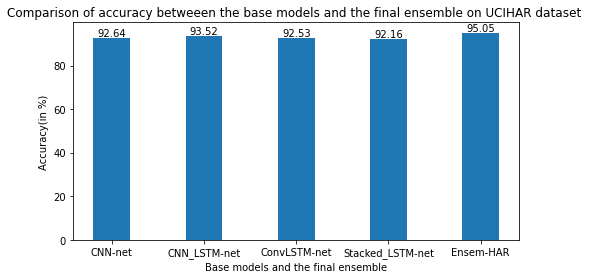

In [45]:
fig = plt.figure(figsize=(8,4))
plt.bar(model_acc.keys(),model_acc.values(),width=0.4)
y=list(model_acc.values())
plt.xlabel("Base models and the final ensemble")
plt.ylabel("Accuracy(in %)")
plt.title("Comparison of accuracy betweeen the base models and the final ensemble on UCIHAR dataset ")
for i in range(5):
    plt.text(i,y[i],"{0:0.2f}".format(y[i]),ha="center",va="bottom")
plt.savefig('Metrics//accuracy_comparison',dpi=1200, bbox_inches='tight')   

In [42]:
pre=np.empty((0,6))
re=np.empty((0,6))
f1_=np.empty((0,6))
for predy in model_pred:
    precision=skm.precision_score(testy, predy, average=None)
    pre=np.vstack([pre,precision])
    recall=skm.recall_score(testy, predy, average=None)
    re=np.vstack([re,recall])
    f1=skm.f1_score(testy, predy, average=None)
    f1_=np.vstack([f1_,f1])

In [43]:
df_pre=pd.DataFrame(pre)
df_pre.columns=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
df_pre.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensemble_HAR']
df_re=pd.DataFrame(re)
df_re.columns=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
df_re.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensemble_HAR']
df_f1=pd.DataFrame(f1_)
df_f1.columns=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
df_f1.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensemble_HAR']

In [44]:
df_pre.to_csv('Precision.csv')
df_re.to_csv('Recall.csv')
df_f1.to_csv('f1_score.csv')

In [46]:
sample_X=[]
sample_y=[]
#creating 10 sample dataset of size 50 from the test data
for i in range(10):
    demo_X=np.empty((50,128,39))
    demo_y=np.empty(50)
    demo_X=testX[(i*200):(i*200)+50]#each sample
    demo_y=testy[(i*200):(i*200)+50]
    sample_X.append(demo_X)# appending to the list of samples
    sample_y.append(demo_y)


In [47]:
# accuracy of each base models and ensemble on 10 sample dataset of size 50 taken from the test data
m1_acc=[]
m2_acc=[]
m3_acc=[]
m4_acc=[]
ensem_acc=[]

for sample,y_testSample in zip(sample_X,sample_y):
    stackSamp=None
    predy_m1=model1.predict([sample,sample,sample,sample])
    predy_m1=np.argmax(predy_m1, axis=-1)
    m1_acc.append(acc(predy_m1,y_testSample))

    stackSamp=predy_m1
    
    predy_m2=model2.predict([sample,sample,sample,sample,sample])
    predy_m2=np.argmax(predy_m2, axis=-1)
    m2_acc.append(acc(predy_m2,y_testSample))

    stackSamp=dstack((predy_m2,stackSamp))
    
    sample3 = sample.reshape((sample.shape[0], n_steps, n_length,9))
    predy_m3=model3.predict(sample3)
    predy_m3=np.argmax(predy_m3, axis=-1)
    m3_acc.append(acc(predy_m3,y_testSample))

    stackSamp=dstack((predy_m3,stackSamp))
    
    predy_m4=model4.predict(sample)
    predy_m4=np.argmax(predy_m4, axis=-1)
    m4_acc.append(acc(predy_m4,y_testSample))

    stackSamp=dstack((predy_m4,stackSamp))
    
    stackSamp = stackSamp.reshape((stackSamp.shape[0]*stackSamp.shape[1],stackSamp.shape[2]))
    predy_en=EnsemHAR.predict(stackSamp)
    ensem_acc.append(acc(predy_en,y_testSample))

In [48]:
ranking=pd.DataFrame()
ranking['CNN-net']=m1_acc
ranking['CNN_LSTM-net']=m2_acc
ranking['ConvLSTM-net']=m3_acc
ranking['Stacked_LSTM-net']=m4_acc
ranking['Ensem-HAR']=ensem_acc

In [50]:
ranking.to_csv('accuracies.csv')